In [1]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("eurosat/rgb", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.KH0K40_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [2]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
total_samples = info.splits['train'].num_examples

print(f"Total samples: {total_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Total samples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [3]:
train_size = 0.8
train_data = dataset['train'].take(int(total_samples * train_size))
val_data = dataset['train'].skip(int(total_samples * train_size))

In [4]:
import tensorflow as tf

IMG_SIZE = 64

def preprocess(image, label, augment=False):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, label

In [5]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_loader = (
    train_data
    .map(lambda x, y: preprocess(x, y, augment=True), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_loader = (
    val_data
    .map(lambda x, y: preprocess(x, y, augment=False), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

###📊 Exploratory Data Analysis (EDA) & Feature Engineering
In this section, we :

 • ✔ Explore the EuroSAT dataset distribution and balance between classes.

 • ✔ Visualize random samples of satellite images for each land cover type.

 • ✔ Analyze pixel intensity distributions to understand color patterns.

 • ✔ Compare original vs augmented images to verify preprocessing.

 • ✔ Compute dataset statistics (mean, std) that can be used for normalization.

 • ✔ Plot Pie Charts to visualize class balance in a more intuitive way.

 • ✔ Perform Variability Analysis within classes to understand internal diversity.

 • ✔ Build a Heatmap of Class Similarities based on mean RGB values across land cover types.

This structured analysis helps us better understand the data before training, identify possible challenges (e.g., class imbalance), and improve model robustness using feature engineering.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import collections
import tensorflow as tf
import seaborn as sns
import collections
import random

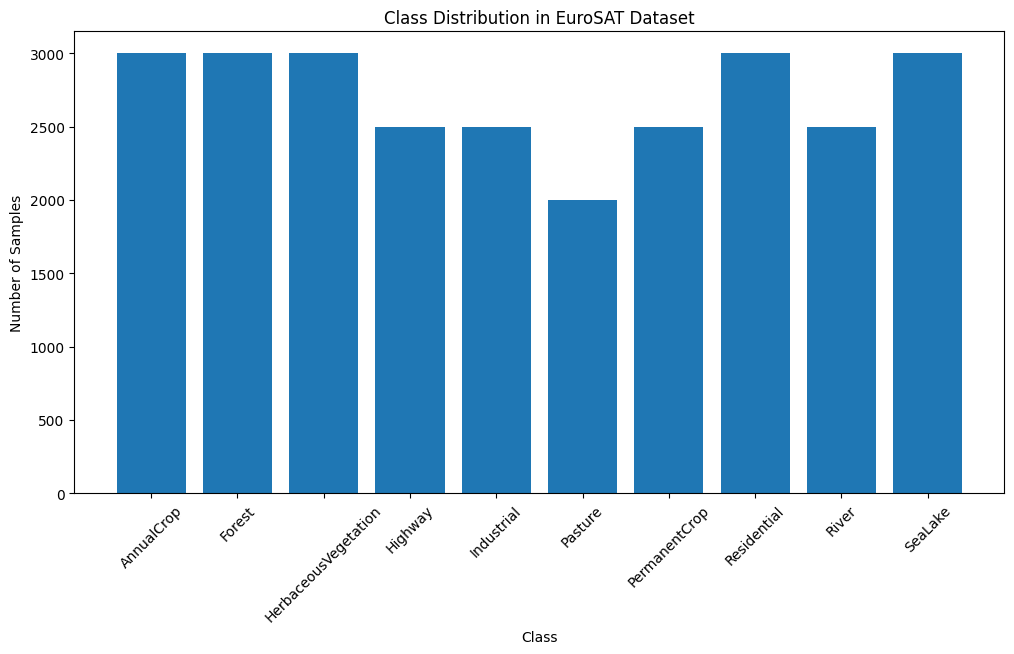

In [7]:
label_counts = collections.Counter()
for _, label in dataset['train']:
    label_counts[int(label.numpy())] += 1

plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), [label_counts[i] for i in range(num_classes)])
plt.xticks(range(num_classes), class_names, rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

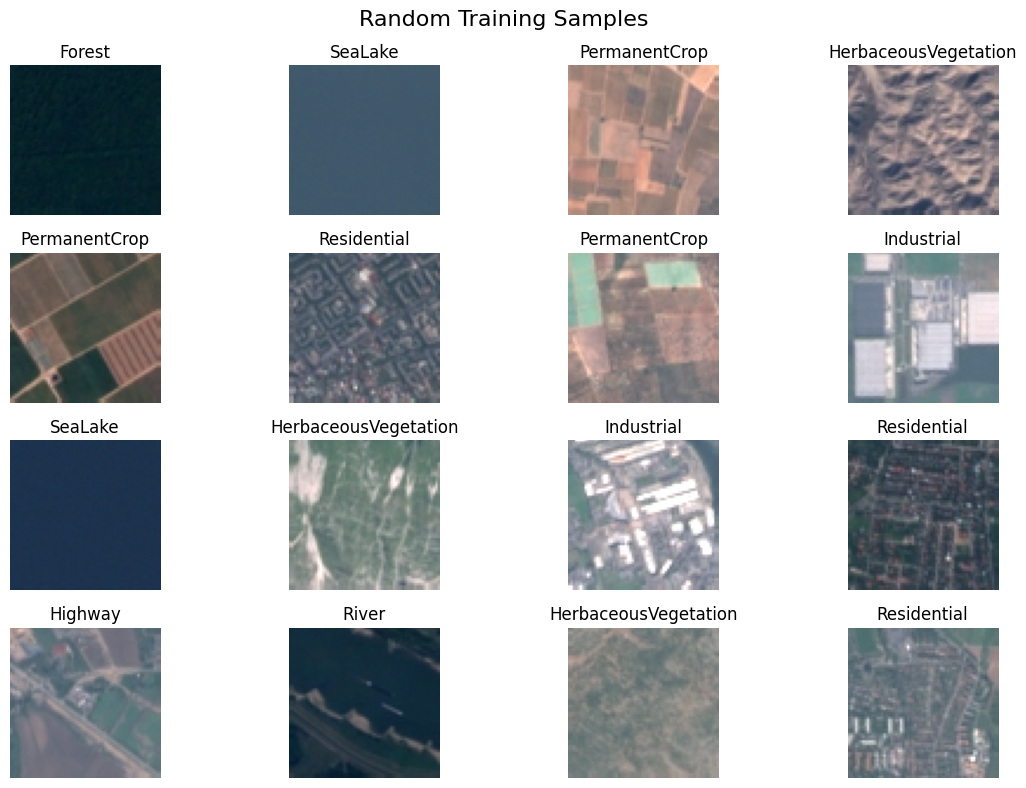

In [8]:
for images, labels in train_loader.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(min(16, images.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.suptitle("Random Training Samples", fontsize=16)
    plt.tight_layout()
    plt.show()
    break

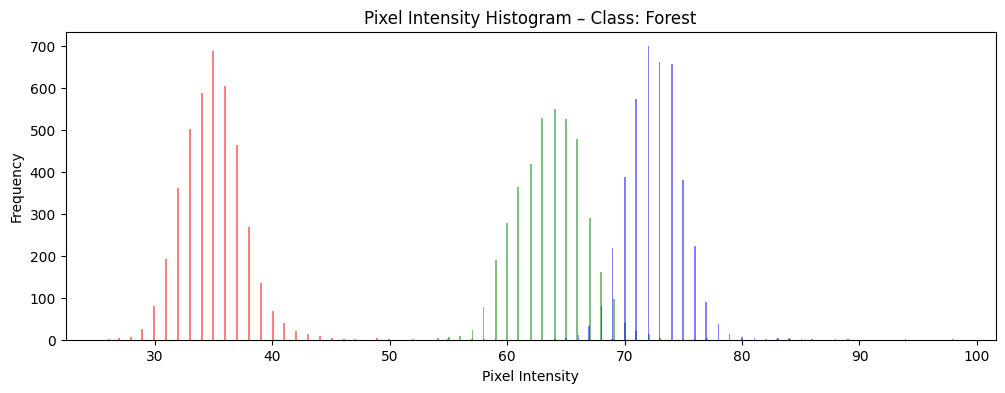

In [9]:
raw_train = dataset['train'].take(1)
for image, label in raw_train:
    plt.figure(figsize=(12, 4))
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        plt.hist(image.numpy()[:, :, i].ravel(), bins=256, color=color, alpha=0.5)
    plt.title(f"Pixel Intensity Histogram – Class: {class_names[label.numpy()]}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()
    break


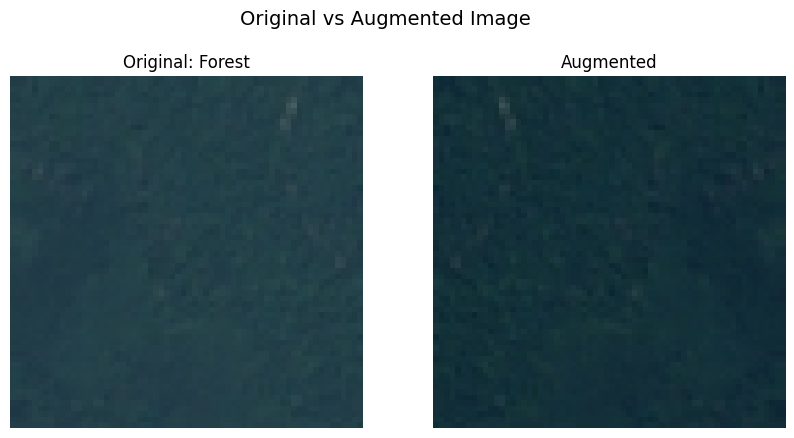

In [10]:
for image, label in dataset['train'].take(1):
    plt.figure(figsize=(10, 5))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title(f"Original: {class_names[label.numpy()]}")
    plt.axis("off")

    # Augmented
    aug_img, _ = preprocess(image, label, augment=True)
    plt.subplot(1, 2, 2)
    plt.imshow(aug_img.numpy())
    plt.title("Augmented")
    plt.axis("off")

    plt.suptitle("Original vs Augmented Image", fontsize=14)
    plt.show()
    break

In [11]:
channel_sum = np.zeros(3)
channel_sum_sq = np.zeros(3)
num_samples = 0

for img, _ in dataset['train'].take(2000):
    img = tf.cast(img, tf.float32) / 255.0
    img_np = img.numpy()
    channel_sum += img_np.mean(axis=(0, 1))
    channel_sum_sq += (img_np ** 2).mean(axis=(0, 1))
    num_samples += 1

mean = channel_sum / num_samples
std = np.sqrt(channel_sum_sq / num_samples - mean ** 2)

print("Channel Means (R,G,B):", mean)
print("Channel Stds (R,G,B):", std)

Channel Means (R,G,B): [0.34675499 0.38444264 0.40615458]
Channel Stds (R,G,B): [0.20865788 0.1413617  0.11896122]


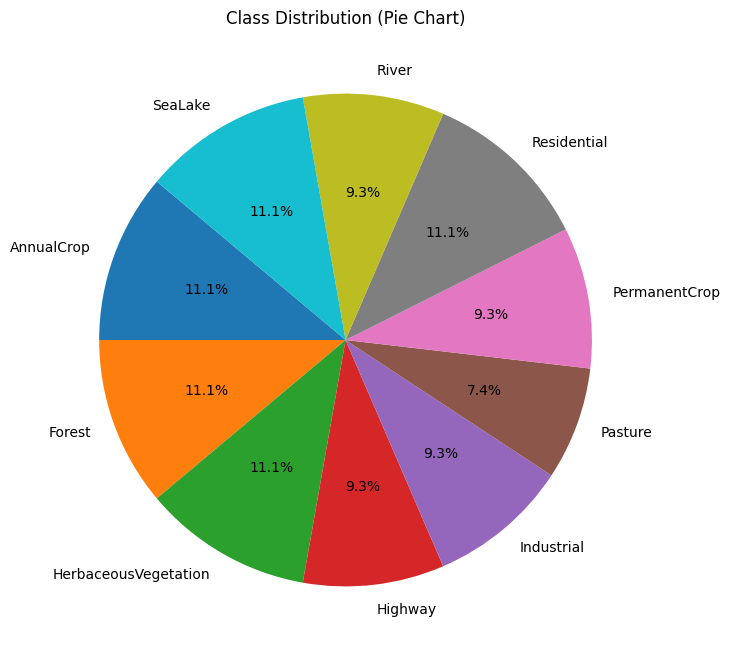

In [12]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names


label_counts = collections.Counter()
for _, label in dataset['train']:
    label_counts[int(label.numpy())] += 1

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    [label_counts[i] for i in range(num_classes)],
    labels=class_names,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Class Distribution (Pie Chart)")
plt.show()



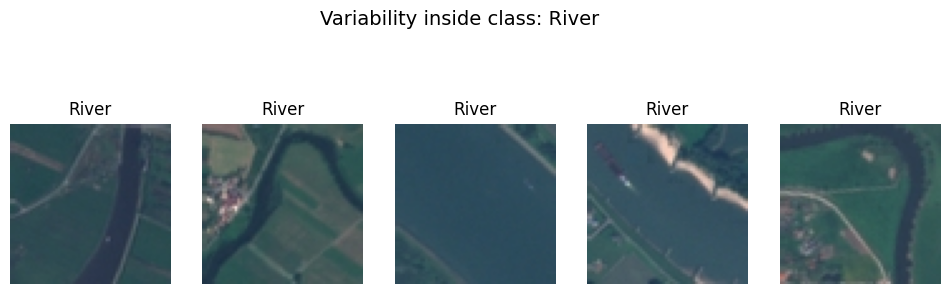

In [13]:
target_class = "River"
target_class_idx = class_names.index(target_class)


images_of_class = []
for img, label in dataset['train']:
    if label.numpy() == target_class_idx:
        images_of_class.append(img)
    if len(images_of_class) >= 5:
        break

plt.figure(figsize=(12, 4))
for i, img in enumerate(images_of_class):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.numpy())
    plt.title(target_class)
    plt.axis("off")
plt.suptitle(f"Variability inside class: {target_class}", fontsize=14)
plt.show()

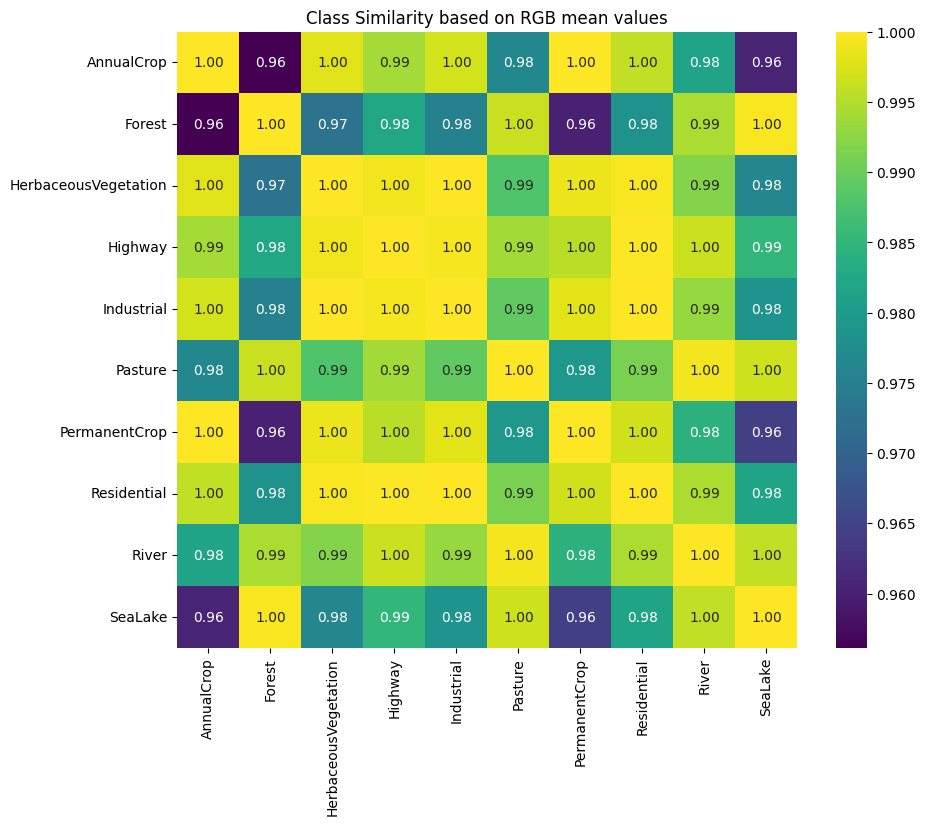

In [14]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names


class_means = np.zeros((num_classes, 3))
counts = np.zeros(num_classes)

for img, label in dataset['train']:
    idx = label.numpy()
    img = img.numpy().astype("float32") / 255.0
    class_means[idx] += img.mean(axis=(0,1))
    counts[idx] += 1


for i in range(num_classes):
    class_means[i] /= counts[i]


from numpy.linalg import norm

similarity = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        dot = np.dot(class_means[i], class_means[j])
        similarity[i, j] = dot / (norm(class_means[i]) * norm(class_means[j]))


plt.figure(figsize=(10,8))
sns.heatmap(similarity, xticklabels=class_names, yticklabels=class_names, annot=True, cmap="viridis", fmt=".2f")
plt.title("Class Similarity based on RGB mean values")
plt.show()

###✅ Summary of Phase 2 Work
 • We successfully performed Exploratory Data Analysis (EDA): visualized class distribution, inspected random samples, analyzed pixel intensity patterns, and explored dataset balance.

 • We applied Feature Engineering:

 • Normalization using computed channel statistics (mean & std).

 • Data Augmentation (flips, brightness, contrast) to improve generalization.

 • Additional insights with pie charts, variability analysis, and a similarity heatmap.


➡️ The dataset is now cleaned, well-understood, and preprocessed, fully ready for Phase 3: Model Training & Validation.

#Phase 3 Model Training & Validation

**Basline Model**



In [15]:
from tensorflow.keras import layers, models

IMG_SIZE = 64

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(
   train_loader,
    validation_data=val_loader,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3674 - loss: 1.6316 - val_accuracy: 0.6422 - val_loss: 0.9555
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6611 - loss: 0.9146 - val_accuracy: 0.7087 - val_loss: 0.7878
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7176 - loss: 0.7738 - val_accuracy: 0.7633 - val_loss: 0.6569
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7517 - loss: 0.6900 - val_accuracy: 0.7854 - val_loss: 0.6008
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7730 - loss: 0.6414 - val_accuracy: 0.7819 - val_loss: 0.6307
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7933 - loss: 0.5757 - val_accuracy: 0.8106 - val_loss: 0.5303
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8165 - loss: 0.5049 - val_accuracy: 0.8487 - val_loss: 0.4260
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8363 - loss: 0.4648 - val_accura

**Pretrained Model**

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

IMG_SIZE = 224

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = True
for layer in base_model.layers[:-8]:
    layer.trainable = False

model_vgg16 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

opt = SGD(learning_rate=1e-4, momentum=0.9)


model_vgg16.compile(optimizer=opt,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

def resize_images(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_loader_resized = train_loader.map(resize_images)
val_loader_resized = val_loader.map(resize_images)


history_vgg16 = model_vgg16.fit(
    train_loader_resized,
    validation_data=val_loader_resized,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 253s 336ms/step - accuracy: 0.1560 - loss: 2.2805 - val_accuracy: 0.5172 - val_loss: 1.4913
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 310ms/step - accuracy: 0.4284 - loss: 1.5848 - val_accuracy: 0.5941 - val_loss: 1.0483
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 311ms/step - accuracy: 0.5439 - loss: 1.2629 - val_accuracy: 0.7417 - val_loss: 0.7876
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 209s 310ms/step - accuracy: 0.6203 - loss: 1.0504 - val_accuracy: 0.7226 - val_loss: 0.7743
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 311ms/step - accuracy: 0.6716 - loss: 0.9220 - val_accuracy: 0.8093 - val_loss: 0.5804
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 310ms/step - accuracy: 0.7122 - loss: 0.8069 - val_accuracy: 0.7441 - val_loss: 0.7074
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 311ms/step - accuracy: 0.7501 - loss: 0.7186 - val_accuracy: 0.8078 - val_loss: 0.5711
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 210s 311ms/step - accuracy: 0.7736 -

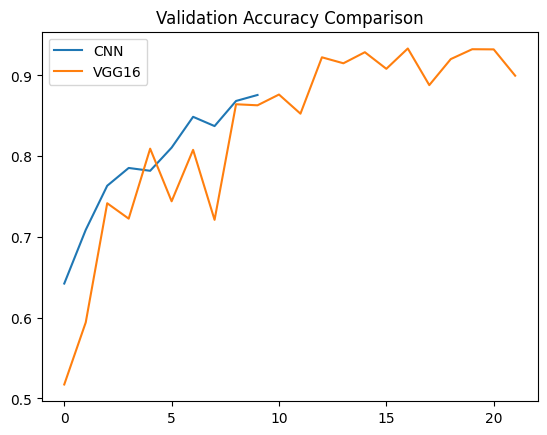

In [20]:
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16')
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()


==== Baseline Model Evaluation ====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

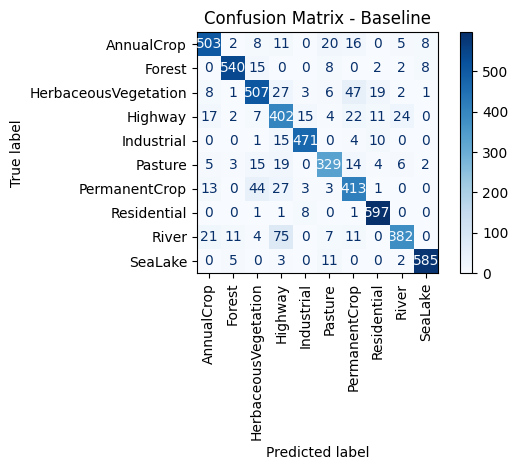


Classification Report - Baseline
                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.88      0.88       573
              Forest       0.96      0.94      0.95       575
HerbaceousVegetation       0.84      0.82      0.83       621
             Highway       0.69      0.80      0.74       504
          Industrial       0.94      0.94      0.94       501
             Pasture       0.85      0.83      0.84       397
       PermanentCrop       0.78      0.82      0.80       504
         Residential       0.93      0.98      0.95       608
               River       0.90      0.75      0.82       511
             SeaLake       0.97      0.97      0.97       606

            accuracy                           0.88      5400
           macro avg       0.88      0.87      0.87      5400
        weighted avg       0.88      0.88      0.88      5400



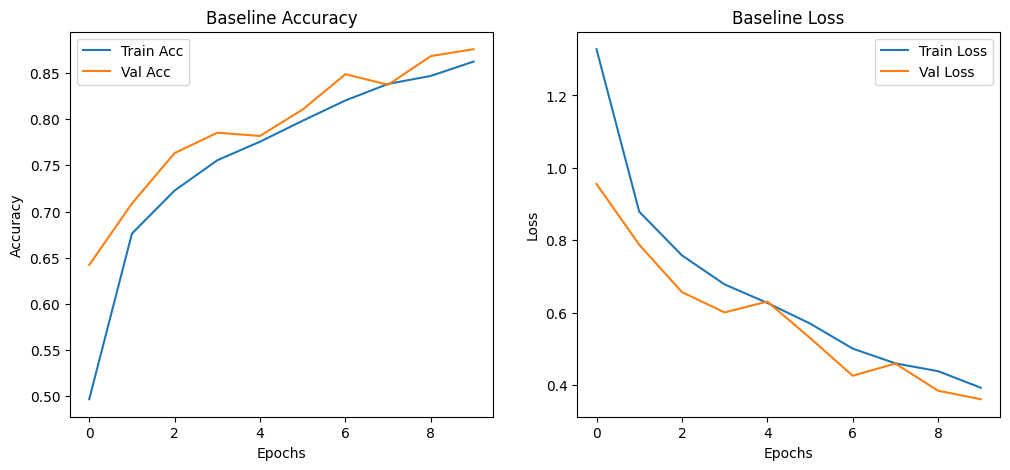


==== VGG16 Model Evaluation ====
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms

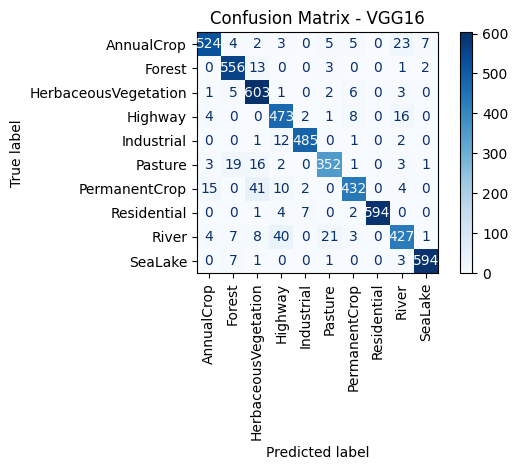


Classification Report - VGG16
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.91      0.93       573
              Forest       0.93      0.97      0.95       575
HerbaceousVegetation       0.88      0.97      0.92       621
             Highway       0.87      0.94      0.90       504
          Industrial       0.98      0.97      0.97       501
             Pasture       0.91      0.89      0.90       397
       PermanentCrop       0.94      0.86      0.90       504
         Residential       1.00      0.98      0.99       608
               River       0.89      0.84      0.86       511
             SeaLake       0.98      0.98      0.98       606

            accuracy                           0.93      5400
           macro avg       0.93      0.93      0.93      5400
        weighted avg       0.93      0.93      0.93      5400



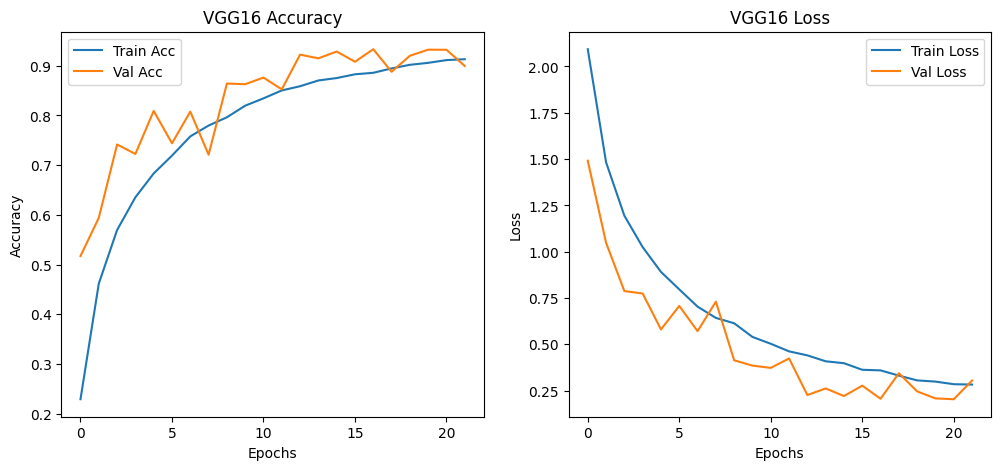

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ===== Function to evaluate model =====
def evaluate_model(model, val_loader, model_name="Model"):
    # Get predictions
    y_true, y_pred = [], []
    for images, labels in val_loader:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

# ===== Plot Training Curves =====
def plot_training(history, model_name="Model"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# ===== Run for both models =====
print("==== Baseline Model Evaluation ====")
evaluate_model(model_cnn, val_loader, model_name="Baseline")
plot_training(history_cnn, "Baseline")

print("\n==== VGG16 Model Evaluation ====")
evaluate_model(model_vgg16, val_loader_resized, model_name="VGG16")
plot_training(history_vgg16, "VGG16")

In [ ]:
# model_cnn.save("model_baseline.keras")
# model_vgg16.save("model_vgg16.keras")

# model_cnn.export("model_baseline_savedmodel")
# model_vgg16.export("model_vgg16_savedmodel")


Saved artifact at 'model_baseline_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134230459607248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230457356304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445493136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445493328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445494096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445492752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445491792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445492944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445493520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134230445493712: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved ar

In [24]:
# from google.colab import files
# files.download("model_baseline.keras")
# files.download("model_vgg16.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🧠 Model Development and Results

## 1. Baseline CNN Model  
- **Architecture**:  
  - Simple Convolutional Neural Network (CNN).  
  - Consists of Conv2D + MaxPooling layers followed by Dense layers.  
- **Goal**: Build a baseline to compare with transfer learning models.  
- **Training**:  
  - Trained for 10 epochs with batch size 32.  
  - Optimizer: Adam.  
  - Loss Function: Categorical Crossentropy.  
- **Results**:  
  - **Overall Accuracy**: **88%**  
  - **Class-wise Performance**:  
    - *Forest*: 95% F1-score  
    - *SeaLake*: 97% F1-score  
    - *Highway*: 74% F1-score  
    - *River*: 82% F1-score  
  - **Observations**: Solid benchmark with good performance, but struggles on visually complex or overlapping classes.  

---

## 2. VGG16 (Transfer Learning)  
- **Architecture**:  
  - Pre-trained VGG16 used as a feature extractor.  
  - Added custom Dense layers for classification.  
- **Goal**: Leverage transfer learning to improve accuracy and generalization.  
- **Training**:  
  - Frozen convolutional base of VGG16.  
  - Fine-tuned top layers with custom classifier.  
- **Results**:  
  - **Overall Accuracy**: **93%**  
  - **Class-wise Performance**:  
    - *Residential*: 99% F1-score  
    - *Industrial*: 97% F1-score  
    - *SeaLake*: 98% F1-score  
    - *Highway*: 90% F1-score  
    - *HerbaceousVegetation*: 92% F1-score  
  - **Observations**: Transfer learning with VGG16 significantly improved generalization, especially for classes where the baseline struggled. The model is more robust and consistent across categories.  

---

## 3. Model Saving  
- Baseline CNN: `model_baseline.keras`  
- VGG16 Model: `model_vgg16.keras`  

---

## 📊 Baseline vs VGG16 Comparison

| Metric              | Baseline CNN | VGG16 (Transfer Learning) |
|---------------------|--------------|----------------------------|
| **Overall Accuracy** | 88%          | 93%                        |
| **Strongest Class**  | SeaLake (97%)| Residential (99%)          |
| **Weakest Class**    | Highway (74%)| River (86%)                |
| **Generalization**   | Moderate     | Strong                     |

---

## ➡️ Conclusion  
- The **Baseline CNN** achieved 88% accuracy and provided a strong starting point.  
- The **VGG16 transfer learning model** outperformed the baseline with **93% accuracy**, showing better results on challenging classes.  
- Use the **VGG16 model** for deployment due to its higher accuracy and balanced performance across classes.
